In [48]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

~~So out of 300 total parameter runs, 244 are gabbage parameters.~~    
__TODO:__    
1. ~~Plot histograms of the NAN parameter values to find possible cluster points of the gabbage parameters~~
1. ~~Plot non gabbage parameters vs relative RMSE and $L^2$ error. Try to find regions of best fit for the parameters, as well as regions of less significant gains in lower errors~~

__Done:__    
1. Running a random search to optimize the following parameters:
    - network layer size
    - learning rate
    - epoch
    - batch size
    - latent dimension
    - coarse scale dimension: not yet implemented
1. Greatest challenge encounted was in dynamically choosing network layers input-output sizes.We settled for randomly choosing integers from the intervals $[\frac{n_f}{2^{i+1}}, \frac{n_f}{2^{i}}], \cdots, [\frac{n_f}{2^{2}}, \frac{n_f}{2^{1}}]$ for $i = m, m-1, \cdots, 1, 0$ where $m$ is the number of layers and $n_f$, the number of fine scale elements. This works but could not go beyond $m=10$ layers.

In [49]:
# the lattest result
with open('params_optim.pickle', 'rb') as f:
    resultn = pickle.load(f)
df = pd.DataFrame.from_dict(resultn)
# divide latent dimension by 2 since it is shared between mean and variance
df['latent_dim'] = df['latent_dim'] //2
df.head()

num_layers  learning_rate  epoch  batch_size  latent_dim layer_inputs  \
0           1       0.038584      7          57          91  [2001, 182]   
1           1       0.038584      7          57          91  [2001, 182]   
2           1       0.038584      7          57          91  [2001, 182]   
3           1       0.038584      7          57          91  [2001, 182]   
4           1       0.038865    386         141          41   [2001, 82]   

   relativeRMSE  relativeL2error  
0           NaN              NaN  
1           NaN              NaN  
2           NaN              NaN  
3           NaN              NaN  
4           NaN              NaN

In [50]:
# layers run so far
np.unique(df['num_layers'].values)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
# total number of model runs so far
len(df)

347670

In [52]:
# count how many nans in all the rows
df.isna().sum().sum()/2 # sice there are two NAN columns

301700.0

In [53]:
# Slice df by NAN values of relativeRMSE
df_NA = df.loc[df.relativeRMSE.isna(), ['num_layers', 'learning_rate', 'epoch', 'batch_size', 'latent_dim']]
df_NA.head()

num_layers  learning_rate  epoch  batch_size  latent_dim
0           1       0.038584      7          57          91
1           1       0.038584      7          57          91
2           1       0.038584      7          57          91
3           1       0.038584      7          57          91
4           1       0.038865    386         141          41

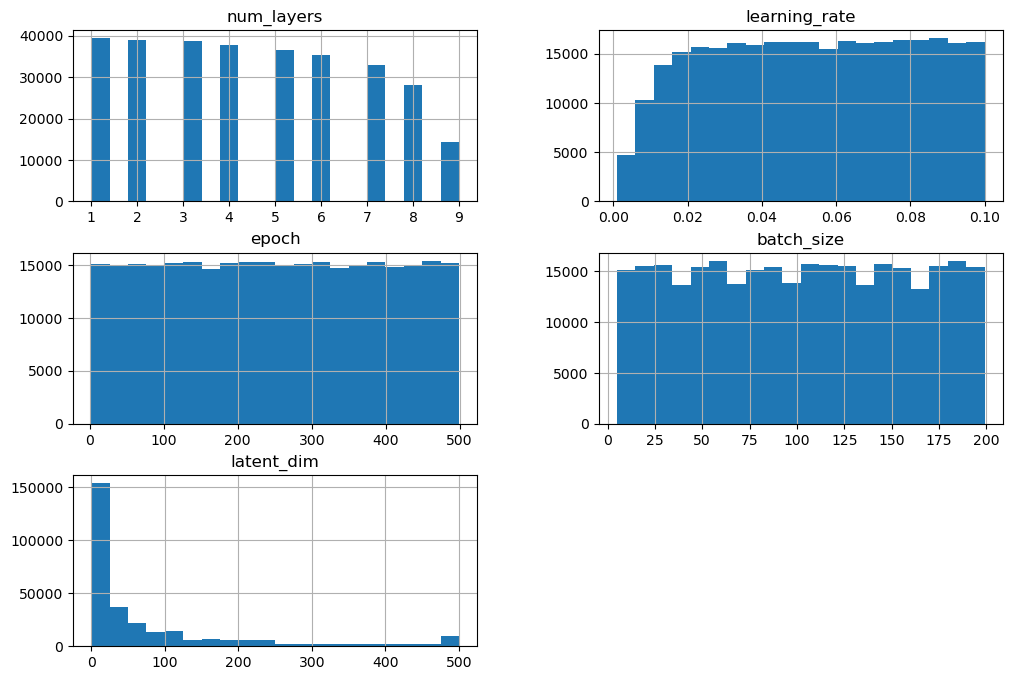

In [54]:
df_NA.hist(bins=20, figsize=(12, 8))
plt.show()

The histogram for `latent dimension` suggests there are more `nan` values for smaller latent dimensions. A hasty conclusion is to assume higher latent dimensions would yield better model. Check this with the actual errors.   
For other hyperparameters, there is no sign of favoritism to certain aspect of the hyperparameter spaces.

In [55]:
# Slice df1 by NAN values of relativeRMSE
df_noNA = df.loc[~df.relativeRMSE.isna(), ['num_layers', 'learning_rate', 'epoch', 'batch_size', 'latent_dim', 'relativeRMSE', 'relativeL2error']]
df_noNA.head()

num_layers  learning_rate  epoch  batch_size  latent_dim  relativeRMSE  \
88            1       0.000768    352         117         256      0.053460   
89            1       0.000768    352         117         256      0.053223   
90            1       0.000768    352         117         256      0.054361   
91            1       0.000768    352         117         256      0.053851   
488           1       0.001583    159          64         233      0.843299   

     relativeL2error  
88         42.658733  
89         42.318136  
90         43.642089  
91         43.568729  
488        45.751659

In [56]:
# layers run so far for non NANs RMSE
np.unique(df_noNA['num_layers'].values)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

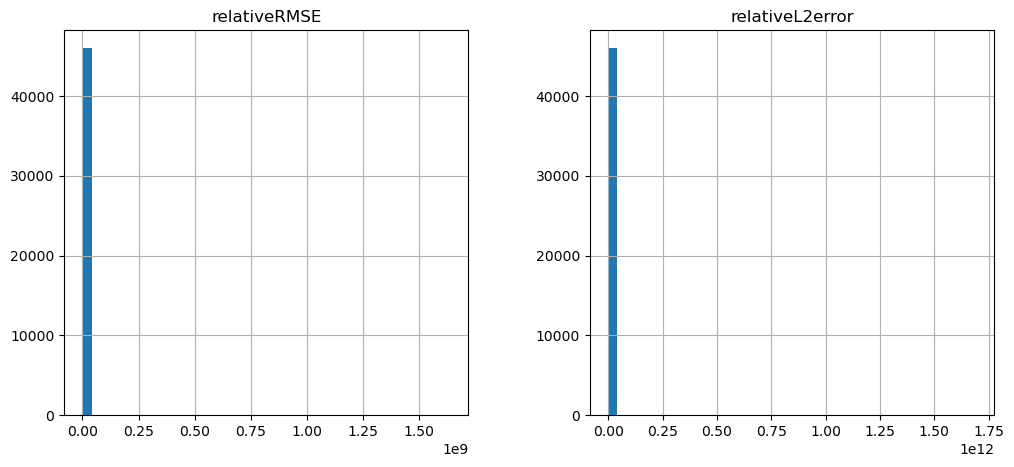

In [57]:
df_noNA[['relativeRMSE', 'relativeL2error']].hist(bins=40, figsize=(12, 5))
plt.show()

In [58]:
len(df_noNA)    # number of hyperparameters for which test errors are not NANs

45970

Plot Parameters against Relative RMSE and L2 Norm

Higher number of layers seem to have signifcant effect in lowering the both errors.

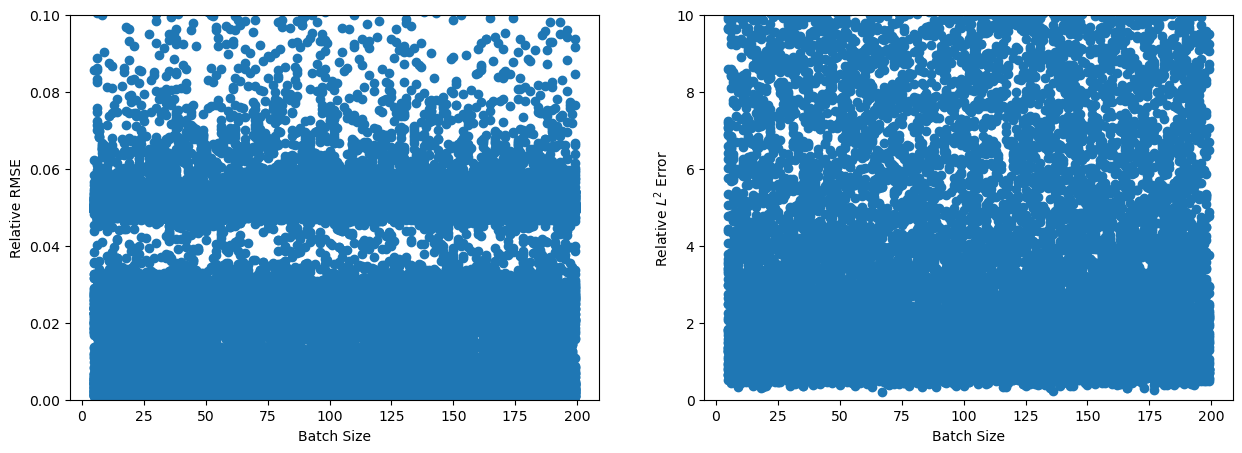

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(df_noNA['batch_size'].values, df_noNA['relativeRMSE'].values)
axes[1].scatter(df_noNA['batch_size'].values, df_noNA['relativeL2error'].values)
####### Label axes ########
yaxis = ['Relative RMSE', r'Relative $L^2$ Error']
for i in range(2):
    axes[i].set_xlabel("Batch Size")
    axes[i].set_ylabel(yaxis[i])
###########################
axes[0].set_ylim([0,0.1])      # plot against relative RMSE
axes[1].set_ylim([0,10])       # plot against relative  L2 norm
plt.show()

So far batch size does not seem to have any significant effect on the both errors. See the plot above.

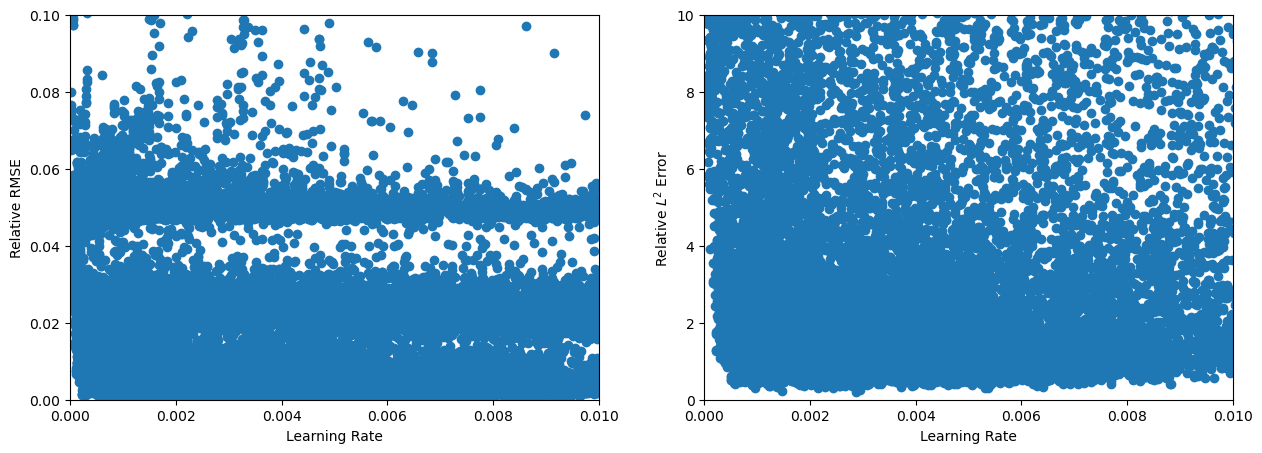

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(df_noNA['learning_rate'].values, df_noNA['relativeRMSE'].values)
axes[1].scatter(df_noNA['learning_rate'].values, df_noNA['relativeL2error'].values)
####### Label axes ########
yaxis = ['Relative RMSE', r'Relative $L^2$ Error']
for i in range(2):
    axes[i].set_xlabel("Learning Rate")
    axes[i].set_ylabel(yaxis[i])
###########################
axes[0].set_ylim([0,0.1])      # plot against relative RMSE
axes[1].set_ylim([0,10])       # plot against relative  L2 norm
axes[0].set_xlim([0, 0.01])
axes[1].set_xlim([0, 0.01])
plt.show()

As expected for Adam optimizer which requires a very small learning rate, learning rates between $0$ and $0.01$ show significant dominance in lowering relative RMSE.

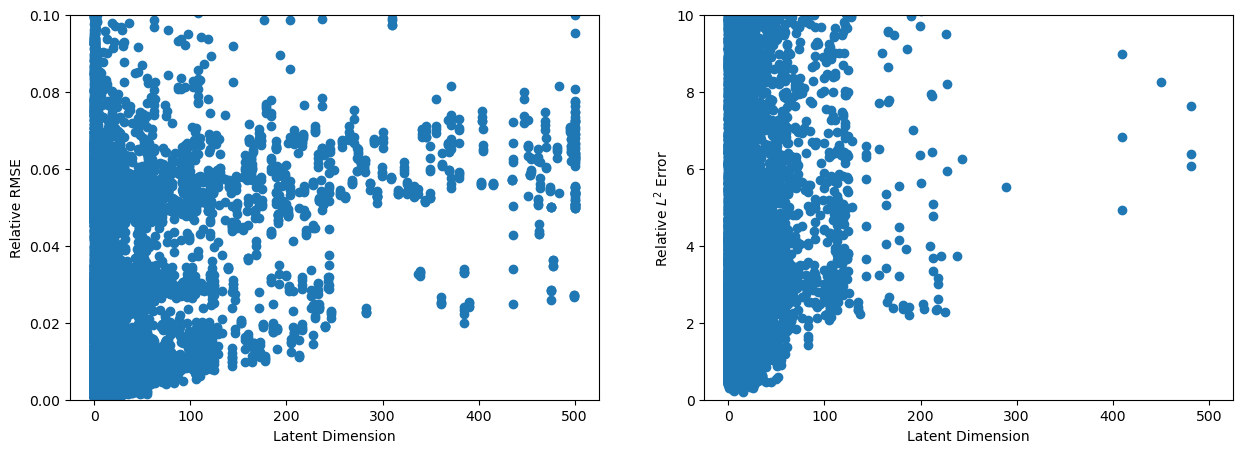

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(df_noNA['latent_dim'].values, df_noNA['relativeRMSE'].values)
axes[1].scatter(df_noNA['latent_dim'].values, df_noNA['relativeL2error'].values)
####### Label axes ########
yaxis = ['Relative RMSE', r'Relative $L^2$ Error']
for i in range(2):
    axes[i].set_xlabel("Latent Dimension")
    axes[i].set_ylabel(yaxis[i])
###########################
axes[0].set_ylim([0,0.1])      # plot against relative RMSE
axes[1].set_ylim([0,10])       # plot against relative  L2 norm
plt.show()

In [62]:
# Find the of the min relative RMSE
idx = np.argmin(df_noNA['relativeRMSE'].values)
idx

13432

In [63]:
# find the latent dimension that minimizes relative
df_noNA['latent_dim'].values[idx]

2

The latent dimension that minimizes relative RMSE is 6. Given that there is just one random variable in the parameter $q(x, \xi)$ of the model, it is expected that the latent dimension be as small as possible. In fact, we postulate that the latent dimension of a CVAE learns only the stochaticity/randomness of the model while the decoder, conditioned on the coarse scale solution, which we assume carries the functional nature of the fine solution, reconstructs the original solution.
One explanation as to why the latent dimension is high relative to the number of random variables (6:1 for relative RMSE and 18:1 for relative L2 norm) is that the latent dimension not only learns the randomness, but also pays attention to the roughness of the parameter $q(x,\xi)$. An extensive experiment is required to valid this, but current empirical evidence is affirmative.  

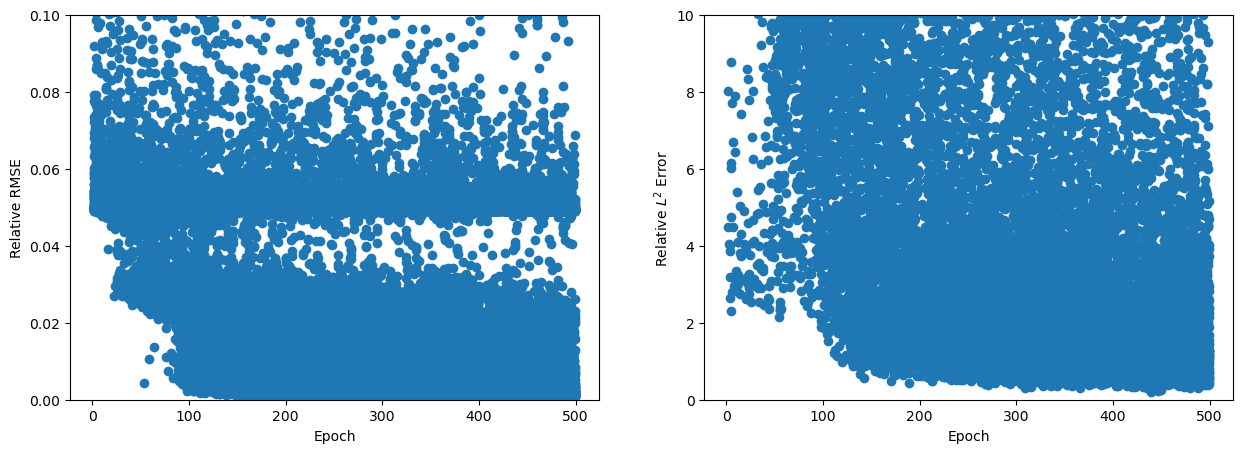

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(df_noNA['epoch'].values, df_noNA['relativeRMSE'].values)
axes[1].scatter(df_noNA['epoch'].values, df_noNA['relativeL2error'].values)
####### Label axes ########
yaxis = ['Relative RMSE', r'Relative $L^2$ Error']
for i in range(2):
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel(yaxis[i])
###########################
axes[0].set_ylim([0,0.1])      # plot against relative RMSE
axes[1].set_ylim([0,10])       # plot against relative  L2 norm
plt.show()

An epoch between 300 and 500 seem to have significant effect in bringing down both the relative RMSE and L2 norms.    
Overall, the L2 norm even though has higher errors, demonstrate robustness and seem to be a better choice for capturing the distributions of the hyperparameters as partains to their effects on model.

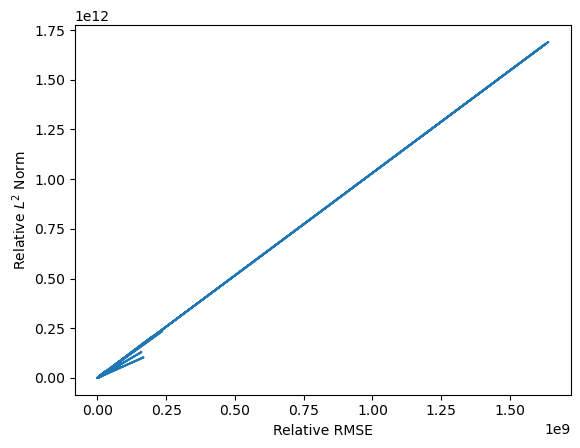

In [65]:
# plot relative RMSE against relative L2 Norm
plt.plot(df_noNA["relativeRMSE"], df_noNA["relativeL2error"])
plt.xlabel("Relative RMSE")
plt.ylabel(r"Relative $L^2$ Norm")
plt.show()

Obviously, from this plot, there is no difference in both norms, since they perfectly align, that is, they both minimize and maximize simultaneously. This is definitely expected since the RMSE is just the discrete version of the $L^2$ norm. However, $L^2$ norm seem to be robust in terms of deciding regions of the best fit in the hyperparameter spaces.

### Compare Hyperparameters by Number of Layers

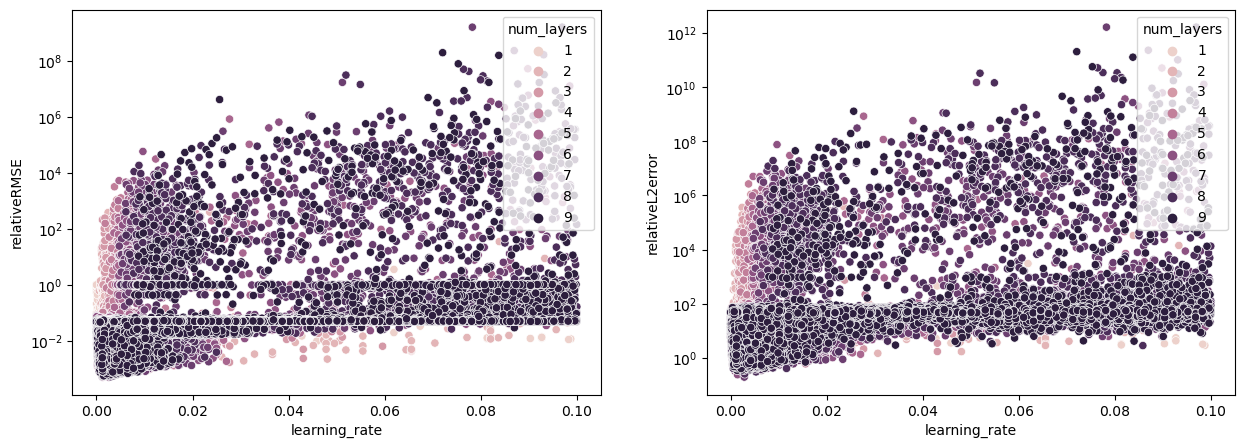

In [66]:
# effect of layers on learning rate
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(df_noNA, x='learning_rate', y='relativeRMSE', hue='num_layers', ax=axes[0], legend='full')
sns.scatterplot(df_noNA, x='learning_rate', y='relativeL2error', hue='num_layers', ax=axes[1], legend='full')
axes[0].set_yscale('log')       # plot against log relative RMSE
axes[1].set_yscale('log')       # plot against log relative  L2 norm

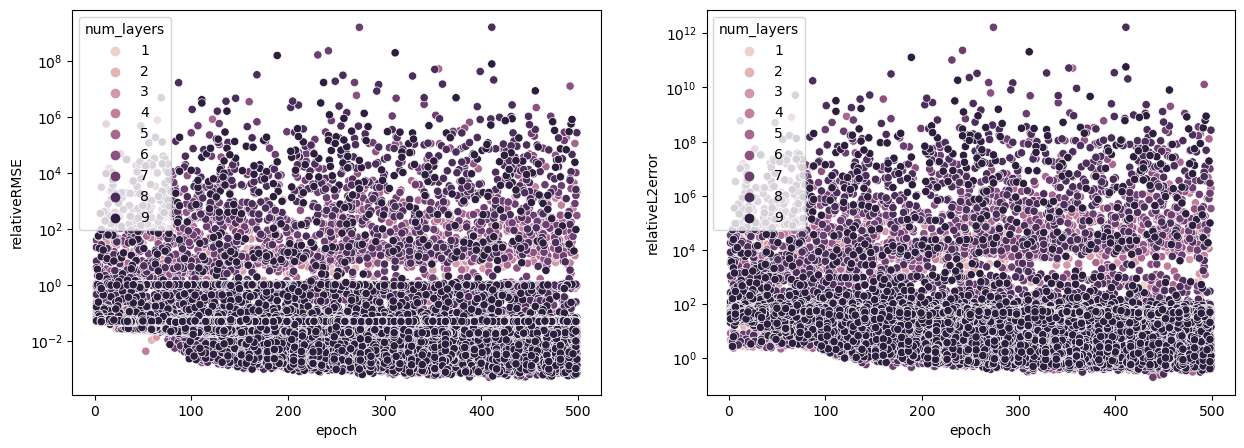

In [67]:
# effect of layers on epoch
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(df_noNA, x='epoch', y='relativeRMSE', hue='num_layers', ax=axes[0], legend='full')
sns.scatterplot(df_noNA, x='epoch', y='relativeL2error', hue='num_layers', ax=axes[1], legend='full')
axes[0].set_yscale('log')       # plot against log relative RMSE
axes[1].set_yscale('log')       # plot against log relative  L2 norm

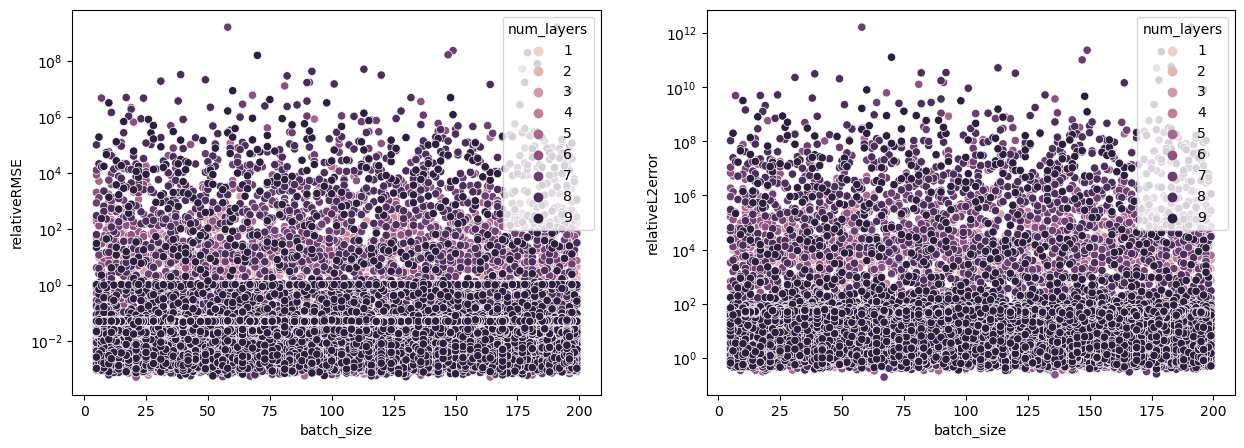

In [68]:
# effect of layers on batch size
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(df_noNA, x='batch_size', y='relativeRMSE', hue='num_layers', ax=axes[0], legend='full')
sns.scatterplot(df_noNA, x='batch_size', y='relativeL2error', hue='num_layers', ax=axes[1], legend='full')
axes[0].set_yscale('log')       # plot against log relative RMSE
axes[1].set_yscale('log')       # plot against log relative  L2 norm

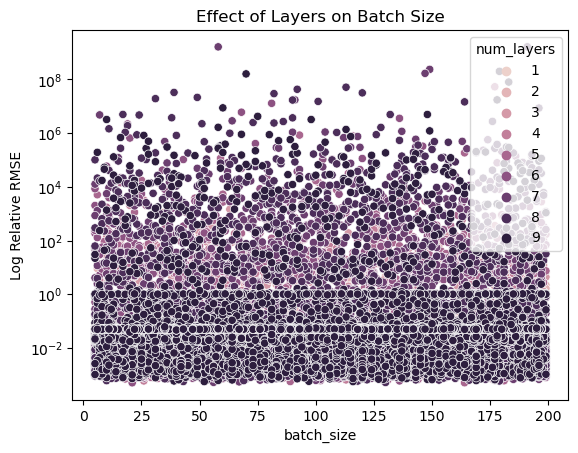

In [69]:
############## For Oral Presentation ################
# effect of layers on batch size
sns.scatterplot(df_noNA, x='batch_size', y='relativeRMSE', hue='num_layers', legend='full')
plt.yscale('log')       # plot against log relative RMSE
plt.title('Effect of Layers on Batch Size')
plt.ylabel('Log Relative RMSE')
plt.show()

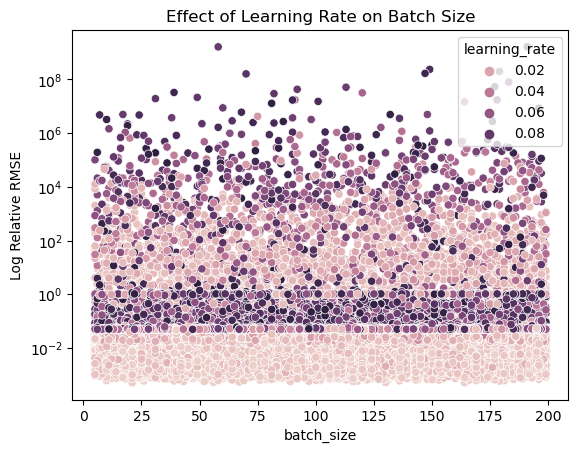

In [70]:
############## For Oral Presentation ################
# effect of learning on batch size
sns.scatterplot(df_noNA, x='batch_size', y='relativeRMSE', hue='learning_rate')
plt.yscale('log')       # plot against log relative RMSE
plt.title('Effect of Learning Rate on Batch Size')
plt.ylabel('Log Relative RMSE')
plt.show()

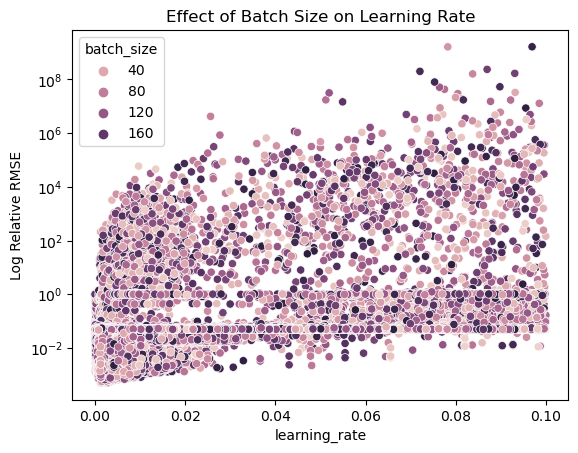

In [71]:
############## For Oral Presentation ################
# effect of batch size on learning rate
sns.scatterplot(df_noNA, x='learning_rate', y='relativeRMSE', hue='batch_size')
plt.yscale('log')       # plot against log relative RMSE
plt.title('Effect of Batch Size on Learning Rate')
plt.ylabel('Log Relative RMSE')
plt.show()

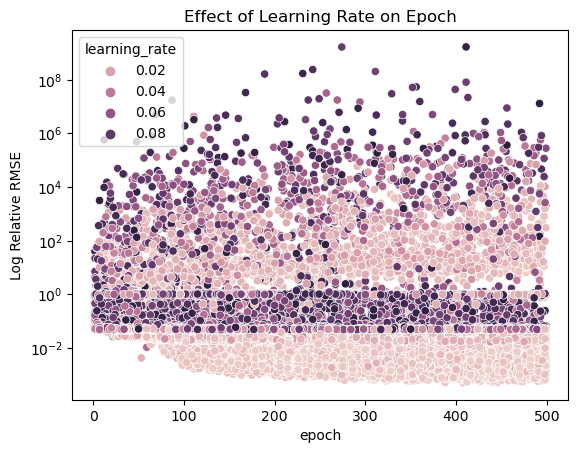

In [72]:
############## For Oral Presentation ################
# effect of learning on epoch
sns.scatterplot(df_noNA, x='epoch', y='relativeRMSE', hue='learning_rate')
plt.yscale('log')       # plot against log relative RMSE
plt.title('Effect of Learning Rate on Epoch')
plt.ylabel('Log Relative RMSE')
plt.show()


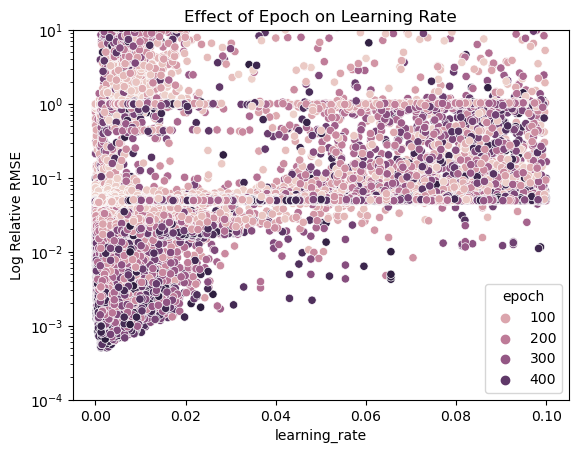

In [73]:
############## For Oral Presentation ################
# effect of epoch  on learning rate
sns.scatterplot(df_noNA, x='learning_rate', y='relativeRMSE', hue='epoch')
plt.yscale('log')       # plot against log relative RMSE
plt.ylim(1e-4, 1e1)
plt.title('Effect of Epoch on Learning Rate')
plt.ylabel('Log Relative RMSE')
plt.show()

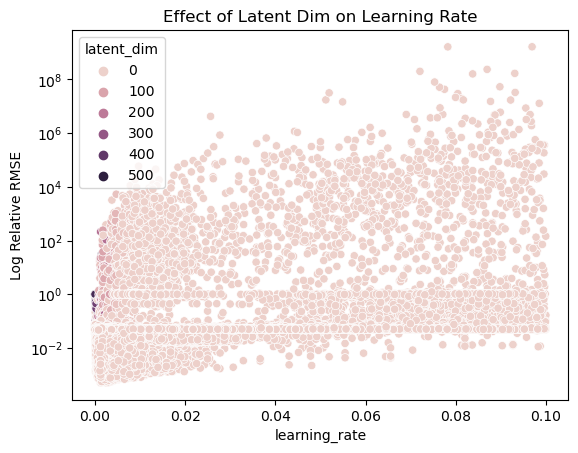

In [74]:
############## For Oral Presentation ################
# effect of epoch  on learning rate
sns.scatterplot(df_noNA, x='learning_rate', y='relativeRMSE', hue='latent_dim')
plt.yscale('log')       # plot against log relative RMSE
# plt.ylim(1e-4, 1e1)
plt.title('Effect of Latent Dim on Learning Rate')
plt.ylabel('Log Relative RMSE')
plt.show()

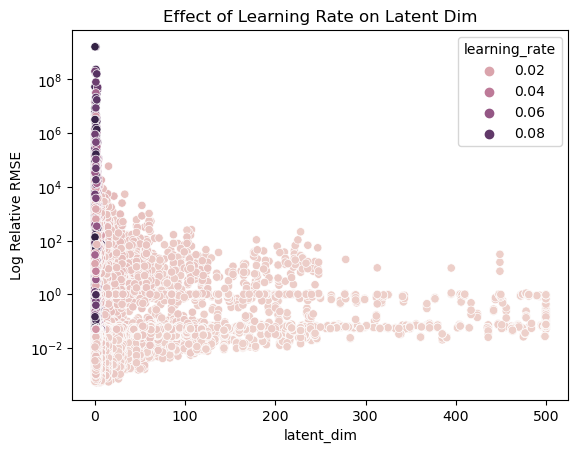

In [75]:
############## For Oral Presentation ################
# effect of epoch  on learning rate
sns.scatterplot(df_noNA, x='latent_dim', y='relativeRMSE', hue='learning_rate')
plt.yscale('log')       # plot against log relative RMSE
# plt.ylim(1e-4, 1e1)
plt.title('Effect of Learning Rate on Latent Dim')
plt.ylabel('Log Relative RMSE')
plt.show()

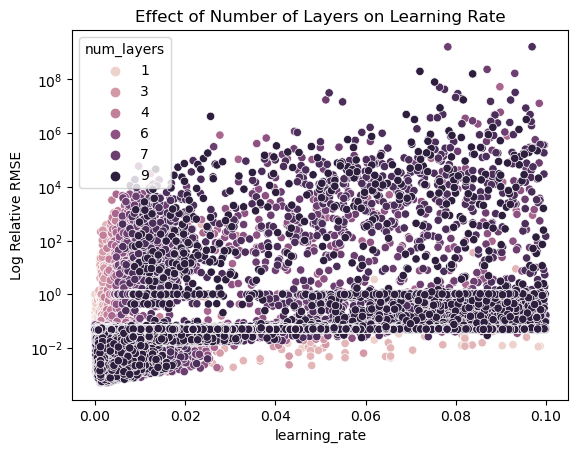

In [76]:
############## For Oral Presentation ################
# effect of epoch  on learning rate
sns.scatterplot(df_noNA, x='learning_rate', y='relativeRMSE', hue='num_layers')
plt.yscale('log')       # plot against log relative RMSE
# plt.ylim(1e-4, 1e1)
plt.title('Effect of Number of Layers on Learning Rate')
plt.ylabel('Log Relative RMSE')
plt.show()

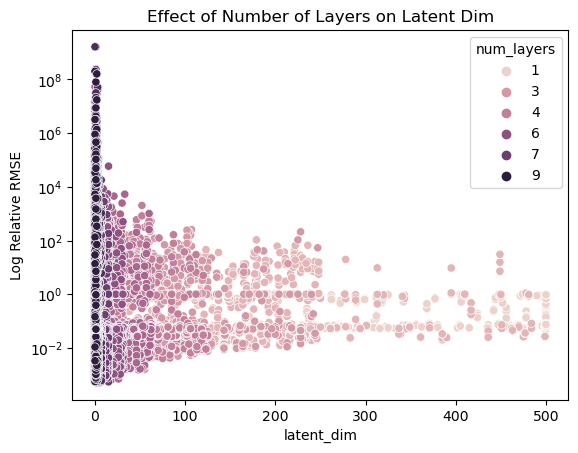

In [77]:
############## For Oral Presentation ################
# effect of epoch  on learning rate
sns.scatterplot(df_noNA, x='latent_dim', y='relativeRMSE', hue='num_layers')
plt.yscale('log')       # plot against log relative RMSE
# plt.ylim(1e-4, 1e1)
plt.title('Effect of Number of Layers on Latent Dim')
plt.ylabel('Log Relative RMSE')
plt.show()

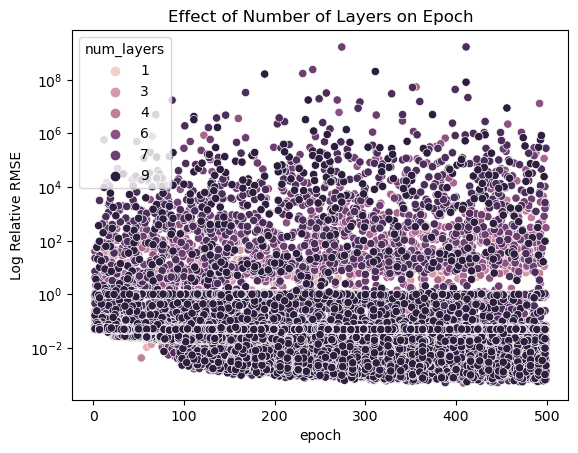

In [78]:
############## For Oral Presentation ################
# effect of epoch  on learning rate
sns.scatterplot(df_noNA, x='epoch', y='relativeRMSE', hue='num_layers')
plt.yscale('log')       # plot against log relative RMSE
# plt.ylim(1e-4, 1e1)
plt.title('Effect of Number of Layers on Epoch')
plt.ylabel('Log Relative RMSE')
plt.show()

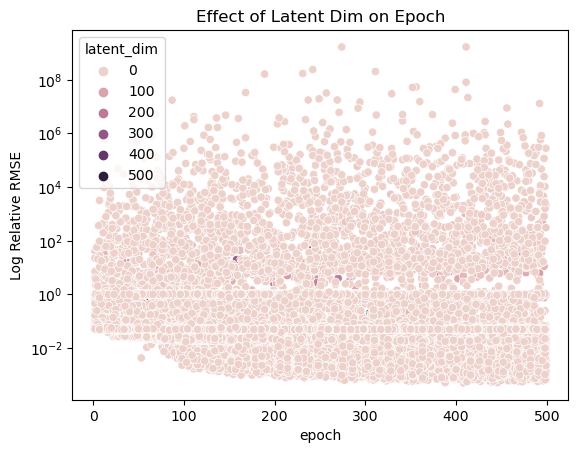

In [89]:
############## For Oral Presentation ################
# effect of Latent Dim  on learning rate
sns.scatterplot(df_noNA, x='epoch', y='relativeRMSE', hue='latent_dim')
plt.yscale('log')       # plot against log relative RMSE
# plt.ylim(1e-4, 1e1)
plt.title('Effect of Latent Dim on Epoch')
plt.ylabel('Log Relative RMSE')
plt.show()

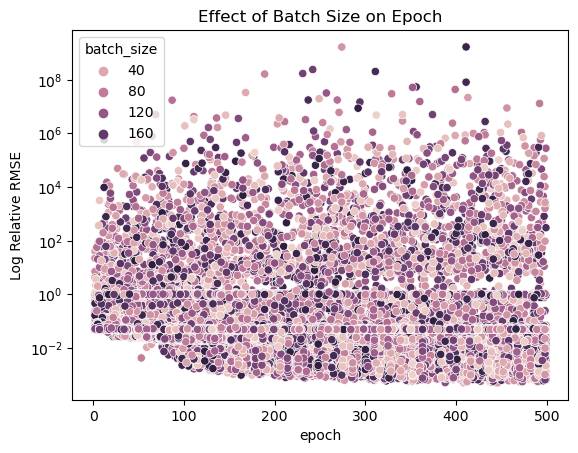

In [88]:
############## For Oral Presentation ################
# effect of Latent Dim  on learning rate
sns.scatterplot(df_noNA, x='epoch', y='relativeRMSE', hue='batch_size')
plt.yscale('log')       # plot against log relative RMSE
# plt.ylim(1e-4, 1e1)
plt.title('Effect of Batch Size on Epoch')
plt.ylabel('Log Relative RMSE')
plt.show()

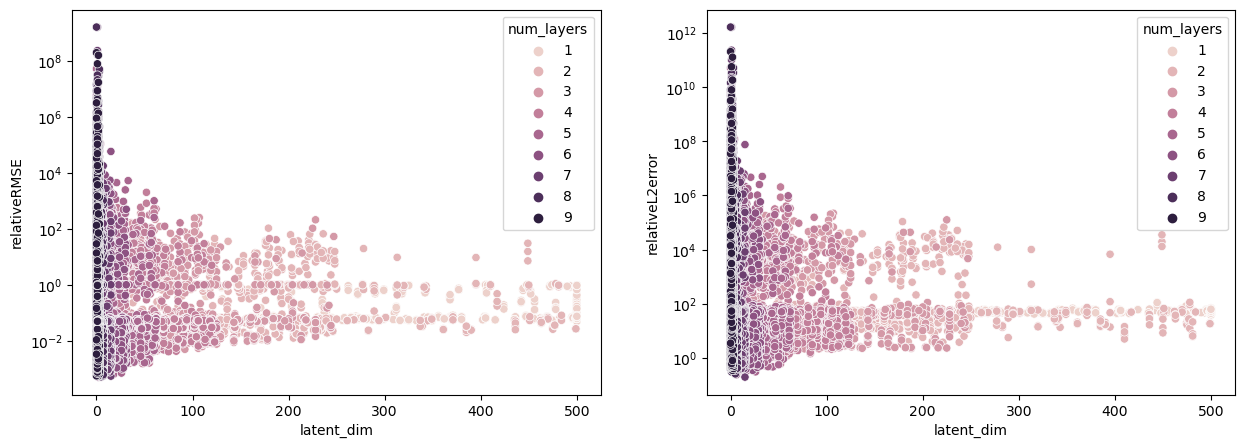

In [79]:
# effect of layers on latent dimension
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(df_noNA, x='latent_dim', y='relativeRMSE', hue='num_layers', ax=axes[0], legend='full')
sns.scatterplot(df_noNA, x='latent_dim', y='relativeL2error', hue='num_layers', ax=axes[1], legend='full')
axes[0].set_yscale('log')       # plot against log relative RMSE
axes[1].set_yscale('log')       # plot against log relative  L2 norm

Clearly, smaller layers favor higher latent dimension and higher number of layers are okay with smaller latent dimension. We now understand why our `nan` histogram suggests there are more `nan`'s for smaller latent dimension since number of layers so far 5 and there are smaller number of layers than bigger. That is $[1,2,3]$ vs $[4,5]$, if we agree this is a good partition of number layers into small and big, respectively. Essentially, the model seeks to be rich and so more layers or more nodes makes this happen.    

The relative RMSE seem to have three layers of concentration (trid-modal if there is something like that) over all the hyperparameters. Could this be associated with local minima in the RMSE objective? Why is this trend not obtainable in the relative $L^2$ norm? (Remember the model is trained on MSE loss) Could it be the test set is divided into at least, three regions of solutions with different roughness?

Dr. Hans observed from the latent dimension plots that the latent dimension is biased in favor of smaller latent numbers. To get an understanding as to why this occurs, we plot histograms of the latent dimensions for both data with no `nan`'s and the full data.

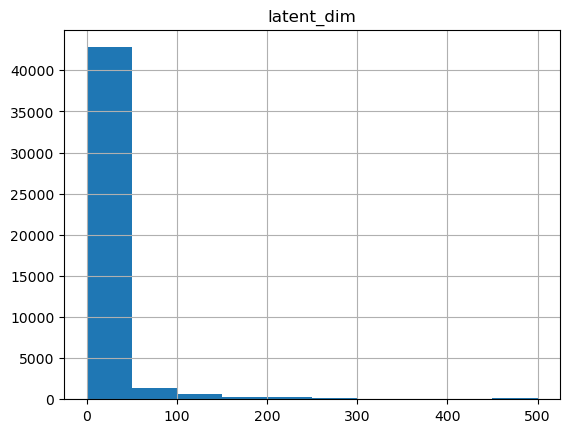

In [80]:
df_noNA.hist(['latent_dim'])
plt.show()

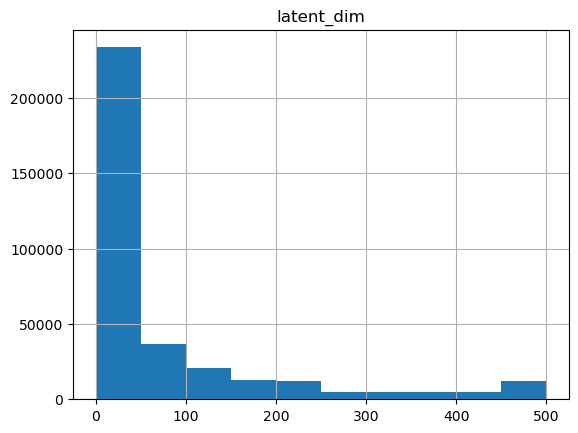

In [81]:
df.hist(['latent_dim'])
plt.show()

The histograms confirm it true - there are more exploration in the range of (1, 50) than possibly all other regions combined. This is completely due to my limited knowledge in defining the choice of regions for the random search to explore. 
Recalled we defined the intervals of exploration to be $[\frac{n_f}{2^{i+1}}, \frac{n_f}{2^{i}}], \cdots, [\frac{n_f}{2^{2}}, \frac{n_f}{2^{1}}]$ for $i = m, m-1, \cdots, 1, 0$. Clearly, for large $m$ (number of layers), the intervals get skewed towards very small latent dimensions because of the exponential decay.

A more plausible and elegant way to resolve this issue is to take the geometry of the autoencoders in account in defining the intervals.
Let     
$m = $ the number of layers for $m = 1, 2, \cdots$     
$\ell = $ latent dimension, $\ell \in \{ 1, 2, \cdots, n_f\}$    
$x = $ a point in $[1, m]$    
$f = $ maps $x$ to the desired interval breakpoints

![Latent Dimension Exploration](latent-dim-explore.jpg)

<!-- <img src="latent-dim-explore.jpg" alt="Latent Dimension Exploration" width="500"> -->

$$
f(x) = \frac{(n-\ell)x -nm + \ell}{1-m}
$$


In [82]:
def net_inp_out_sizes_linear(layers=2, latent_bd=10, in_features=2001):
    m = layers      # number of layers
    ell = latent_bd    # lower bound for latent dimension
    n = in_features    # input size
    if m==1:
        return [n], [np.random.randint(ell, n)]
    else:
        f = lambda x: ((n-ell)*x - n*m + ell)/(1-m) 

        delm = (m-1)/m 
        
        x = np.arange(1, m+delm, delm)
        print(f(x))
        # list of inputs to the encoder
        enc_dec_bds = f(x).astype('int')
        enc_dec_ls = [n]
        for i in range(len(enc_dec_bds)-1):
            inp = np.random.randint(enc_dec_bds[i+1], enc_dec_bds[i])
            enc_dec_ls.append(inp)
        # ensure the last output is divisible by two each for var and mean
        if enc_dec_ls[-1] % 2 == 1:
            enc_dec_ls[-1] = enc_dec_ls[-1] + 1
        # split into ins and outs
        enc_in, enc_out = enc_dec_ls[:-1], enc_dec_ls[1:]
        # enc_in, enc_out
    return enc_in, enc_out

net_inp_out_sizes_linear(latent_bd=1, layers=1)

([2001], [298])